In [570]:
#####HMC Bayesian Hierarchical Logistic regression model#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy
import scipy.linalg
import scipy.stats as ss
import itertools
from numpy.random import *
from scipy import optimize
from scipy.stats import norm
from scipy import sparse

In [571]:
####データの発生####
##データの設定
hh = 10000   #ユーザー数
pt = np.random.poisson(numpy.random.gamma(10, 1/0.2, hh), hh)   #1人あたりのサンプル数
hhpt = np.sum(pt)   #総サンプル数

In [572]:
##IDとインデックスの設定
#IDの設定
user_id = np.repeat(range(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))
ID = pd.DataFrame({"user_id":user_id, "pt_id":pt_id})

#インデックスの設定
index = np.array(range(hhpt))
user_list = [i for i in range(hh)]
for i in range(hh):
    user_list[i] = index[user_id==i]
user_dt = sparse.coo_matrix((np.repeat(1, hhpt), (user_id, range(hhpt))), shape=(hh, hhpt)).tocsr()   #スパース行列の設定

In [573]:
##説明変数の生成
#素性ベクトルを生成
k1 = 5; k2 = 6; k3 = 5
x1 = np.array(np.random.random(hhpt*k1)).reshape((hhpt, k1))
x2 = np.zeros((hhpt, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    x2[:, j] = np.random.binomial(1, prob, hhpt)
x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hhpt)
x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
X = np.concatenate((np.repeat(1, hhpt)[:, np.newaxis], x1, x2, x3), axis=1)
k = X.shape[1]

#階層モデルの説明変数を生成
k1 = 3; k2 = 4; k3 = 5
u1 = np.array(np.random.random(hh*k1)).reshape((hh, k1))
u2 = np.zeros((hh, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    u2[:, j] = np.random.binomial(1, prob, hh)
u3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hh)
u3 = np.delete(u3, np.argmin(np.sum(u3, axis=0)), axis=1)   #冗長な変数の削除
u = np.concatenate((np.repeat(1, hh)[:, np.newaxis], u1, u2, u3), axis=1)
column_u = u.shape[1]

1
2
3
4
5
0.3461126694856965
173607


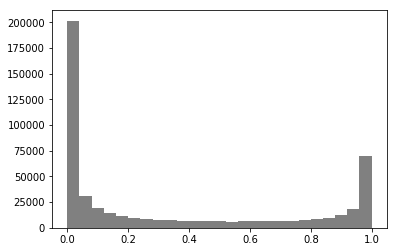

In [574]:
####応答変数の生成####
rp = 0
while True:
    rp = rp + 1
    print(rp)
    
    ##パラメータの生成
    #階層モデルのパラメータを生成
    Cov = np.diag(np.append(0.2, np.random.uniform(0.025, 0.175, k-1)))
    beta = np.hstack((np.append(-0.6, np.random.normal(0, 0.75, column_u-1)).reshape(column_u, 1), 
                      np.random.normal(0, 0.75, column_u*(k-1)).reshape(column_u, k-1)))
    Covt = Cov; betat = beta

    #モデルパラメータを生成
    theta = np.dot(u, beta) + np.random.multivariate_normal(np.repeat(0, k), Cov, hh)
    thetat = theta

    ##応答確率と応答変数を生成
    #ロジットと応答確率を生成
    logit = np.dot(X * theta[user_id, ], np.repeat(1, k))
    Prob = np.exp(logit) / (1 + np.exp(logit))

    #ベルヌーイ分布から応答変数を生成
    y = np.random.binomial(1, Prob, hhpt)
    
    #break条件
    if((np.mean(y) > 0.2) & (np.mean(y) < 0.45)):
        break
        
#生成した応答変数を確認
print(np.mean(y))
print(np.sum(y))
plt.hist(Prob, bins=25, color="grey", histtype="barstacked")
plt.show()

In [575]:
####ハミルトニアンモンテカルロ法で階層ベイズロジスティック回帰モデルを推定####
##対数事後分布を計算する関数
def loglike(theta, y, X, u_mu, inv_Cov, user_id, user_dt, hhpt, k): 
    #ロジットモデルの対数尤度
    mu = np.exp(np.dot(X * theta[user_id, ], np.repeat(1, k)))   #ロジットの指数変換
    Prob = mu / (1 + mu)   
    LLi_logit = y*np.log(Prob) + (1-y)*np.log(1-Prob)   #ロジットモデルの対数尤度

    #多変量正規分布の対数尤度
    er = theta - u_mu   #パラメータの誤差
    LLi_mvn = -1/2 * np.dot(np.dot(er, inv_Cov) * er, np.repeat(1, k))

    #ユーザーごとの対数事後分布
    LLi = np.array(np.dot(user_dt, sparse.csc_matrix(LLi_logit.reshape(hhpt, 1))).todense()).reshape(-1) + LLi_mvn
    return LLi

In [ ]:
##対数事後分布を計算する関数
def loglike(theta, y, X, u_mu, inv_Cov, user_id, user_dt, hhpt, k): 
    #ロジットモデルの対数尤度
    mu = np.exp(np.dot(X * theta[user_id, ], np.repeat(1, k)))   #ロジットの指数変換
    Prob = mu / (1 + mu)   
    LLi_logit = y*np.log(Prob) + (1-y)*np.log(1-Prob)   #ロジットモデルの対数尤度

    #多変量正規分布の対数尤度
    er = theta - u_mu   #パラメータの誤差
    LLi_mvn = -1/2 * np.dot(np.dot(er, inv_Cov) * er, np.repeat(1, k))

    #ユーザーごとの対数事後分布
    LLi = np.array(np.dot(user_dt, sparse.csc_matrix(LLi_logit.reshape(hhpt, 1))).todense()).reshape(-1) + LLi_mvn
    return LLi

In [576]:
##対数事後分布の微分関数
def dloglike(theta, y, X, u_mu, inv_Cov, user_id, user_list, hhpt, k):
    #ロジットモデルの対数尤度
    mu = np.exp(np.dot(X * theta[user_id, ], np.repeat(1, k)))   #ロジットの指数変換
    Prob = mu / (1 + mu)   

    #微分関数の設定
    er = theta - u_mu   #パラメータの誤差
    dlogit = y.reshape(hhpt, 1)*X - Prob.reshape(hhpt, 1)*X   #ロジスティック回帰の対数尤度の微分関数
    dmvn = -np.dot(inv_Cov, er.T).T   #多変量正規分布の対数事前分布の微分関数

    #勾配ベクトルの設定
    dlogit_sums = np.zeros((hh, k))
    for i in range(hh):
        dlogit_sums[i, ] = np.sum(dlogit[user_list[i], ], axis=0)
    LLd = -(dlogit_sums + dmvn)
    return LLd

In [577]:
##リープフロッグ法を解く関数
def leapfrog(r, z, D, e, L): 
    def leapfrog_step(r, z, e):
        r2 = r - e * D(z, y, X, u_mu, inv_Cov, user_id, user_list, hhpt, k) / 2
        z2 = z + e * r2
        r2 = r2 - e * D(z2, y, X, u_mu, inv_Cov, user_id, user_list, hhpt, k) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [578]:
##ベイジアン多変量回帰モデルをギブスサンプリングする関数
def rmultireg(Y, X, inv_XXV, XY, Cov, ADelta, Deltabar, V, nu, n, col, k):
    #事後分布のパラメータを設定
    beta_mu = np.dot(inv_XXV, XY + np.dot(ADelta, Deltabar)).T.reshape(-1)   #平均ベクトル
    sigma = np.kron(Cov, inv_XXV)   #分散共分散行列

    #パラメータをサンプリング
    beta_vec = np.random.multivariate_normal(beta_mu, sigma, 1)
    beta = beta_vec.reshape(col, k, order='F')   #回帰行列に変換

    ##逆ウィシャート分布から分散共分散行列をサンプリング
    #モデル誤差を設定
    mu = np.dot(X, beta)
    er = Y - mu

    #逆ウィシャート分布のパラメータ
    IW_R = np.dot(er.T, er) + V
    Sn = n + nu

    #パラメータをサンプリング
    Cov = scipy.stats.invwishart.rvs(Sn, IW_R, 1)
    return beta, Cov

In [579]:
##アルゴリズムの設定
LL1 = -100000000   #対数尤度の初期値
R = 5000
keep = 2  
iter = 0
burnin = 500/keep
disp = 10
e = 0.1
L = 3

In [580]:
##事前分布の設定
#階層モデルの事前分布
Deltabar = np.zeros((column_u, k))
ADelta =0.01 * np.diag(np.ones(column_u))
nu = k + 1
V = nu * np.diag(np.ones(k))

In [581]:
##データの設定
#階層モデルの定数
uu = np.dot(u.T, u)
inv_uu = np.linalg.inv(np.dot(u.T, u) + ADelta)

In [638]:
##パラメータの真値
#階層モデルのパラメータ
beta = betat
Cov = Covt
u_mu = np.dot(u, beta)
inv_Cov = np.linalg.inv(Cov)

#モデルパラメータ
theta = thetat

In [639]:
##パラメータの初期値
#階層モデルのパラメータ
beta = np.zeros((column_u, k))
Cov = np.diag(np.repeat(0.1, k))
u_mu = np.dot(u, beta)
inv_Cov = np.linalg.inv(Cov)

#モデルパラメータ
theta = np.random.multivariate_normal(np.repeat(0, k), Cov, hh)

In [640]:
##パラメータの格納用配列
THETA = np.zeros((hh, k, int(R/keep)))
BETA = np.zeros((column_u, k, int(R/keep)))
COV = np.zeros((k, k, int(R/keep)))
logl = np.zeros(int(R/keep))

In [641]:
##対数尤度の基準値
#1パラメータモデルの対数尤度
Prob = np.mean(y)
LLst = np.sum(y*np.log(Prob) + (1-y)*np.log(1-Prob))
print(LLst)

#真値の対数尤度
logit = np.dot(X * thetat[user_id, :], np.repeat(1, k))
Prob = np.exp(logit) / (1 + np.exp(logit))
LLbest = np.sum(y*np.log(Prob) + (1-y)*np.log(1-Prob))
print(LLbest)

-323529.68608936865
-116627.0990974299


In [642]:
####ハミルトニアンモンテカルロ法でパラメータをサンプリング####
for rp in range(R):
    
    ##HMVによりユーザー別のパラメータをサンプリング
    #HMCの新しいパラメータを生成
    rold = np.random.multivariate_normal(np.repeat(0, k), np.diag(np.ones(k)), hh)
    thetad = theta

    #リープフロッグ法による1ステップ移動
    res = leapfrog(rold, thetad, dloglike, e, L)
    rnew = res[0]
    thetan = res[1]

    #移動前と移動後のハミルトニアン
    Hnew = -loglike(thetan, y, X, u_mu, inv_Cov, user_id, user_dt, hhpt, k) + np.dot(np.power(rnew, 2), np.repeat(1, k))/2
    Hold = -loglike(thetad, y, X, u_mu, inv_Cov, user_id, user_dt, hhpt, k) + np.dot(np.power(rold, 2), np.repeat(1, k))/2

    #新しいパラメータの採択を決定
    rand = np.random.uniform(0, 1, hh)
    alpha = np.min(np.hstack((np.ones((hh, 1)), np.exp(Hold - Hnew).reshape(hh, 1))), axis=1)

    #alphaの値に基づき新しいthetaを採択
    flag = np.array(alpha > rand, dtype="int").reshape(hh, 1)
    theta = flag*thetan + (1-flag)*thetad


    ##階層モデルのパラメータをサンプリング
    #多変量回帰モデルから回帰行列と分散をサンプリング
    out = rmultireg(theta, u, inv_uu, np.dot(u.T, theta), Cov, ADelta, Deltabar, V, nu, hh, column_u, k)
    beta = out[0]
    u_mu = np.dot(u, beta)
    Cov = out[1]
    inv_Cov = np.linalg.inv(Cov)


    ##サンプリング結果の格納と表示
    if rp%keep==0:
        mkeep = int(rp/keep)
        THETA[:, :, mkeep] = theta
        BETA[:, :, mkeep] = beta
        COV[:, :, mkeep] = Cov

    if rp%disp==0:
        #対数尤度の計算
        logit = np.dot(X * theta[user_id, :], np.repeat(1, k))
        Prob = np.exp(logit) / (1 + np.exp(logit))
        LL = np.sum(y*np.log(Prob) + (1-y)*np.log(1-Prob))

        #サンプリング結果の表示
        print(rp)
        print(np.mean(alpha))
        print(np.round(np.array((LL, LLbest, LLst)), 1))

0
0.9925552383424004
[-214325.4 -116627.1 -323529.7]
10
0.952592890781377
[-158596.2 -116627.1 -323529.7]
20
0.9520860396547894
[-144129.6 -116627.1 -323529.7]
30
0.9512316794868402
[-136959.8 -116627.1 -323529.7]
40
0.9489559412473185
[-132223.7 -116627.1 -323529.7]
50
0.9509675052777029
[-129295.3 -116627.1 -323529.7]
60
0.9522225196026372
[-126787.6 -116627.1 -323529.7]
70
0.9526822866955981
[-125199.7 -116627.1 -323529.7]
80
0.9557171071839521
[-123770.8 -116627.1 -323529.7]
90
0.9548234101061084
[-122592.7 -116627.1 -323529.7]
100
0.9563377783979766
[-121806.5 -116627.1 -323529.7]
110
0.9578715697303581
[-121255.4 -116627.1 -323529.7]
120
0.9570618225693597
[-120498.2 -116627.1 -323529.7]
130
0.9594605468287176
[-120010.2 -116627.1 -323529.7]
140
0.9603330670870593
[-119452.  -116627.1 -323529.7]
150
0.9616386857945799
[-118955.1 -116627.1 -323529.7]
160
0.9630981400230452
[-118678.5 -116627.1 -323529.7]
170
0.9630533755385328
[-118368.  -116627.1 -323529.7]
180
0.9637413599006289

1490
0.9775081375095757
[-113349.4 -116627.1 -323529.7]
1500
0.9773949476302028
[-113478.7 -116627.1 -323529.7]
1510
0.9767941094431221
[-113488.2 -116627.1 -323529.7]
1520
0.977046415795338
[-113385.5 -116627.1 -323529.7]
1530
0.9769641319343105
[-113348.  -116627.1 -323529.7]
1540
0.9772403956963198
[-113454.4 -116627.1 -323529.7]
1550
0.9778569019591414
[-113456.7 -116627.1 -323529.7]
1560
0.9773724589035216
[-113294.2 -116627.1 -323529.7]
1570
0.9778675636053887
[-113298.3 -116627.1 -323529.7]
1580
0.9775728209689692
[-113368.  -116627.1 -323529.7]
1590
0.9771911762251654
[-113317.9 -116627.1 -323529.7]
1600
0.9775968204945273
[-113697.5 -116627.1 -323529.7]
1610
0.9776335008016102
[-113280.7 -116627.1 -323529.7]
1620
0.9784760550351799
[-113413.9 -116627.1 -323529.7]
1630
0.9774718793801678
[-113314.5 -116627.1 -323529.7]


KeyboardInterrupt: 